# Ensemble optimization

This notebook is an example on how to perform an ensemble optimization. It closly follows the procedure described in  
>['Goerz et al. *Physical Review A 90*, 032329 (2014)'](https://doi.org/10.1103/PhysRevA.90.032329)

ToDo: Add futher text

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
%watermark -v --iversions

qutip       4.4.0.dev0+48770fff
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
matplotlib.pylab  1.15.4
CPython 3.6.7
IPython 7.2.0


In [2]:
import krotov
import itertools

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

## Model

### One qubit Hamiltonian

The qubits are realized in two hyperfine levels of a cesium atom. In addition to that, we also have an intermediate and a Rydberg level. The levels are depicted below:
<center><img src="https://journals.aps.org/pra/article/10.1103/PhysRevA.90.032329/figures/1/medium" width="300"/></center>

This is Fig. 1 from the publication.



We label use qutip to get the individual states and the unity matrix for one qubit:

In [3]:
rydberg = qutip.basis(4,3)    # Rydberg level |r>
intermd = qutip.basis(4,2)    # intermediate level |i>
qb_excited = qutip.basis(4,1) # qubit excited state |1>
qb_ground  = qutip.basis(4,0) # qubit ground state |0>

unity_1q = qutip.qeye(4)

Now we set set up the parameters according to the paper and construct the Hamiltonian according to the paper:

\begin{align*}
\hat{\mathcal{H}}_{\mathrm{1q}} &=  \begin{pmatrix}
0 & 0 & \Omega_{\mathrm{B}}(t) & 0 \\
0 & E_1 & 0 & 0 \\
\Omega_{\mathrm{B}}(t) & 0 & \Delta_1 & \Omega_{\mathrm{R}}(t) \\
0 & 0 & \Omega_{\mathrm{R}}(t) & \Delta_2 
\end{pmatrix} \\
&= \Omega_{\mathrm{B}}(t)\bigg( \ket{0}\bra{i} + \ket{i}\bra{0} \bigg) \ 
        + \ \Omega_{\mathrm{R}}(t)\bigg( \ket{r}\bra{i} + \ket{i}\bra{r} \bigg) \ 
        + \ \text{diag}(0,E_1,\Delta_1,\Delta_2) 
\end{align*}

<div class="alert alert-block alert-info">MK: 
    I have never worked with non hermitian Hamiltonians before, so this needs to be double checked
</div>

To account for the decay of the intermediate level, we add a coefficient $-i\gamma$, with $\gamma=\frac{1}{\tau}>0$ to the intermediate level, leading to a non hermitian hamiltonian (also c.f. [the notebook on the lambda system with non hermitian hamiltonian](03_example_lambda_system_rwa_non_hermitian.ipynb)) :

\begin{align*}
\hat{\mathcal{H}}_{\mathrm{1q}} &=  \begin{pmatrix}
0 & 0 & \Omega_{\mathrm{B}}(t) & 0 \\
0 & E_1 & 0 & 0 \\
\Omega_{\mathrm{B}}(t) & 0 & \Delta_1-i\gamma & \Omega_{\mathrm{R}}(t) \\
0 & 0 & \Omega_{\mathrm{R}}(t) & \Delta_2 
\end{pmatrix} 
\end{align*}

In [4]:
# Omega blue
rabi_freq_blue = .1715 # in GHz

# Omega red
rabi_freq_red = .1484 # in GHz

# Diagonal
e1      = 9.100 # in GHz
delta_1 = 1.273 # in GHz
delta_2 = 0     # in GHz

# decay time (in ns)
tau = 150.0 

def get_1q_hams(rabi_freq_blue=rabi_freq_blue, rabi_freq_red=rabi_freq_red, 
                diag=[0,e1,delta_1,delta_2], gamma=1./tau                   
                ):
    
    blue_driving_hamiltonian = rabi_freq_blue * (qb_ground*intermd.dag() +  intermd*qb_ground.dag())
    red_driving_hamiltonian = rabi_freq_red * (rydberg*intermd.dag() +  intermd*rydberg.dag())
    
    # adding diagonal + dissipation   
    eigen_ham = qutip.qdiags(diag,0) + qutip.qdiags([0,0,-1.j*gamma,0],0)
        
    return eigen_ham, blue_driving_hamiltonian, red_driving_hamiltonian

<div class="alert alert-block alert-success">MG: The usual convention for Python function names is get_1q_hams, instead of camel case. Also "global" isn't strictly necessary unless you write to those variables inside the function (but if you prefer to keep it for now, in order to track which non-local variables the function refers to, I don't mind).
</div>

### Two qubit Hamiltonian

We define the controls for the left atom and compose the left and right atom single qubit hamiltonian:
\begin{align}
    \op{\mathcal{H}}_{\text{1q}}^{\ \text{left }} &= \op{\mathcal{H}}_{\text{1q}} \otimes \mathbb{1} & 
    \op{\mathcal{H}}_{\text{1q}}^{\ \text{right}} &= \mathbb{1} \otimes \op{\mathcal{H}}_{\text{1q}}
\end{align}

and combine them to the two qubit hamiltonian

\begin{equation}
    \op{\mathcal{H}}_{\text{2q}} = \op{\mathcal{H}}_{\text{1q}}^{\ \text{right}} 
                                       + \op{\mathcal{H}}_{\text{1q}}^{\ \text{left}}
                                       - u \ket{rr}\bra{rr} 
\end{equation}


In [5]:
rydberg_coupling = .05726 # in GHz

def get_ham_2q(u=rydberg_coupling, **kwargs):
    """  """
    
    rr_ket = qutip.tensor(rydberg,rydberg)
    rr_rr_ineraction = u * rr_ket*rr_ket.dag()
    
    #Get one qubit Hamiltonian
    eigen_ham, blue_driving_hamiltonian, red_driving_hamiltonian = get_1q_hams(**kwargs)
    
    #Left atom hamiltonian
    ### get the non controlled part of the left atom hamiltonian
    ham_1q_l_0 = qutip.tensor(eigen_ham,unity_1q)
    ### ... and the controlled parts
    ham_1q_l_1_blue = [ qutip.tensor( blue_driving_hamiltonian, unity_1q ), lambda x: 1 ]
    ham_1q_l_1_red  = [ qutip.tensor( red_driving_hamiltonian , unity_1q ), lambda x: 1 ]
                 
    #right atom hamiltonian
    ### get the non controlled part of the left atom hamiltonian
    ham_1q_r_0 = qutip.tensor(unity_1q,eigen_ham)
    ### ... and the controlled parts
    ham_1q_r_1_blue = [ qutip.tensor( unity_1q, blue_driving_hamiltonian ) , lambda x: 1 ]
    ham_1q_r_1_red  = [ qutip.tensor( unity_1q,  red_driving_hamiltonian ) , lambda x: 1 ]
    
    
    # get H_0 Hamiltonian (no controls) ...
    ham_2q_0 = ham_1q_r_0 + ham_1q_r_0 - rr_rr_ineraction
    # ... and add the controls
    ham_2q = [ham_2q_0,  ham_1q_l_1_blue, ham_1q_l_1_red,  ham_1q_r_1_blue, ham_1q_r_1_red]
    
    
    return ham_2q


<div class="alert alert-block alert-success">MG: This might be a bit too much. I'd just have get_1q_hams, and then a single additional routine that returns the complete (H, c_ops). In particular, getHam1qL and getHam1qR aren't really necessary.
</div>

<div class="alert alert-block alert-info">MK: I think that should be better. .
</div>

In [6]:
Ham = get_ham_2q()

### Liouvillian
...

<div class="alert alert-block alert-warning">MG: I didn't realize that qutip.liouvillian doesn't work for the nested lists of time-dependent operators. Thus, we should probably define a more general krotov.objectives.liouvillian that does what the above routine does. I think I'll also just want to do the entire conversion (ham, c_ops) -> Liouvillian in krotov.gate_objectives.
</div>

<div class="alert alert-block alert-info">MK: 
    As discussed in the "Issue" section of github, we omit this part and (as already described above) 
    implement the dissipation by using a non hermitian hamiltonian.
</div>

### Cphase gate

The classical cphase gate is given as follows

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbdf3405908>)

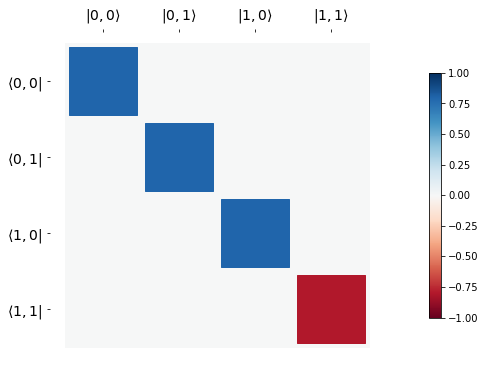

In [7]:
O = qutip.qip.cphase(np.pi)
O
qutip.hinton(O)

However, since we do not only have our qubits with two energy levels, but with four, we have to define the cphase gate as:
\begin{equation}
    \ket{00}\bra{00} + \ket{01}\bra{01} + \ket{10}\bra{10} - \ket{11}\bra{11}
\end{equation}

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbdf304c278>)

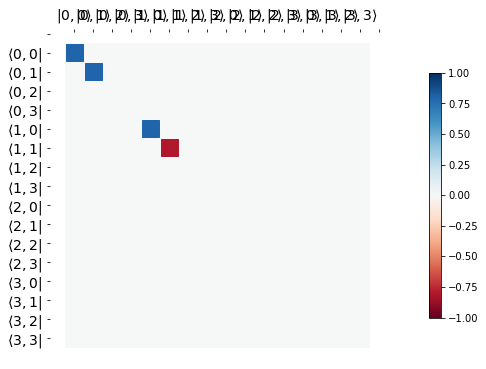

In [8]:
logical_basis=[qutip.tensor(A,B)*qutip.tensor(A,B).dag() for A,B in itertools.product([qb_ground,qb_excited],repeat=2)]

O = sum(logical_basis[:3]) - logical_basis[3]
qutip.hinton(O)

<div class="alert alert-block alert-info">MK: 
    I had problems creating these gates! Is there a more elegant way of doing that?
</div>

## Optimization without ensembles

For the pulse optimization, we define define two guess pulses for each of the atoms:

In [9]:
t_start, t_stop, length = 0, 800, 1600 # in ns
tlist = np.linspace(t_start, t_stop, length)

left_atom_pi_duration = 450 # in ns

def right_atom_pulse(t_start,t_stop):
    func = lambda t,args: krotov.shapes.blackman(t,t_start,t_stop) +1e-16 #account for rounding
    return func

def left_atom_pulse(t_start,t_stop, pi_duration=left_atom_pi_duration):
    func = lambda t,args: krotov.shapes.blackman(t,t_start,t_start+pi_duration)+ \
                          krotov.shapes.blackman(t,t_stop-pi_duration,t_stop)  + 2e-16 #account for rounding
    return func

Which looks like

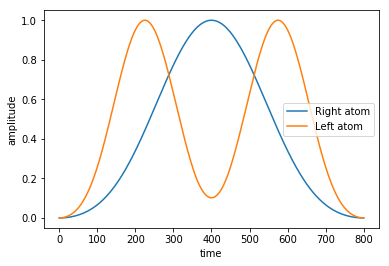

In [10]:
fig, ax = plt.subplots()
ax.plot(tlist, right_atom_pulse(t_start,t_stop)(tlist,None),label='Right atom')
ax.plot(tlist,  left_atom_pulse(t_start,t_stop)(tlist,None),label='Left atom' )
plt.legend()
ax.set_xlabel('time')
ax.set_ylabel('amplitude')
plt.show()

And add the pulses to the Hamiltonian

In [11]:
Ham[1][1] =  left_atom_pulse(t_start,t_stop) #  left atom blue
Ham[2][1] =  left_atom_pulse(t_start,t_stop) #  left atom red
Ham[3][1] = right_atom_pulse(t_start,t_stop) # right atom blue
Ham[4][1] = right_atom_pulse(t_start,t_stop) # right atom red

### Taking into account the gate

In general we would need to define the whole basis of the density matrix of the logical subspace of the system, which is
\begin{align}
    \ket{ij}&\bra{kl} & \forall i,j,k,l \in \{0,1\}
\end{align}

However, Goerz et al. could show, that this in general could be done by using only three density matrices for all gates.
For diagonal gates, this could even be done with two gates.  
&rarr;For furher information c.f. [Goerz et al. PhysRevA.90.032329](http://dx.doi.org/10.1103/PhysRevA.90.032329)

We define the two relevant density matrices

<div class="alert alert-block alert-info">MK: 
    It might be nice to have a function to generate these density matrices! 
</div>

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbdf2c37a58>)

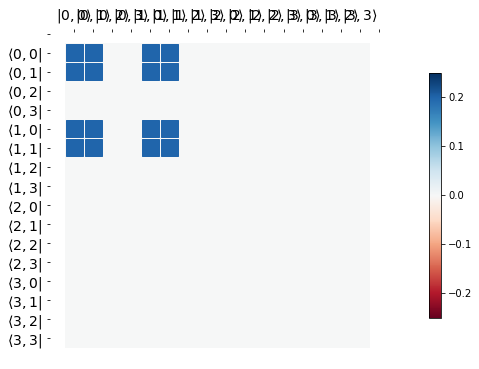

In [12]:
d=4 #Dimension of the hilbert space

# define one atom dm
dm2_array = np.zeros([4,4])
dm2_array[np.ix_([0,1],[0,1])] = 1
dm2_1q = qutip.Qobj(dm2_array)

rho_2 = qutip.tensor(dm2_1q,dm2_1q) * 1/d
qutip.hinton(rho_2)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbdf2c568d0>)

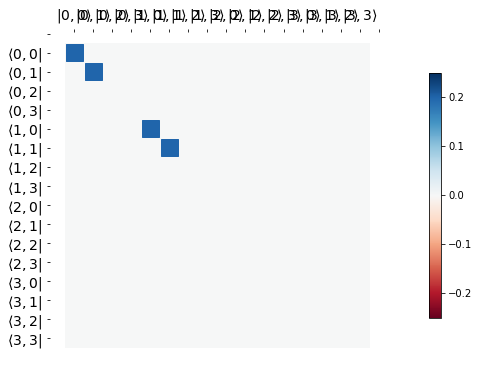

In [13]:
d=4 #Dimension of the hilbert space

# define one atom dm
dm3_array = np.zeros([4,4])
dm3_array[[0,1],[0,1]] = 1
dm3_1q = qutip.Qobj(dm3_array)

rho_3 = qutip.tensor(dm3_1q,dm3_1q) * 1/d
qutip.hinton(rho_3)

For the target states, we set
\begin{align}
    \rho_2 &\longrightarrow \op{O} \rho_2 \op{O}^\dagger \\
    \rho_3 &\longrightarrow \op{O} \rho_3 \op{O}^\dagger
\end{align}

In [14]:
objectives = []
objectives.append(
    krotov.objectives.Objective(initial_state=rho_2, H=Ham, target=O*rho_2*O.dag())
)
objectives.append(
    krotov.objectives.Objective(initial_state=rho_3, H=Ham, target=O*rho_3*O.dag())
)

In [15]:
krotov.objectives.summarize_qobj(Ham)

'[NonHerm[4⊗4,4⊗4], [Herm[4⊗4,4⊗4], u1(t)], [Herm[4⊗4,4⊗4], u2(t)], [Herm[4⊗4,4⊗4], u3(t)], [Herm[4⊗4,4⊗4], u4(t)]]'

<div class="alert alert-block alert-success">MG: There seems to be something wrong here. These should be 4 independent pulses, but it appears that there are only two them are independent (u1 and u2 both appear twice)
</div>

In [16]:
len(objectives)

2

<div class="alert alert-block alert-success">MG: So this is definitely not correct. You cannot optimize a dissipative gate by tracking the density matrices corresponding to the canonical basis states. You need either 16 density matrices corresponding to the canonical states, or 2 specially chosen states (see discussion above Eq 14)
</div>

<div class="alert alert-block alert-info">MK: 
    I now generated the objectives on my own.
    Do you think it would be a good idea to also show how to use the `gate_objective` routine (for the 16 dm)?
    Or should we change this as soon as the `gate_objective` routine is aware of returning the 2 (or 3) dms?
</div>

In [17]:
lambda_11 = lambda_21 = lambda_31 = lambda_41 = .1

pulse_options = {
    Ham[1][1]: krotov.PulseOptions(lambda_a=lambda_11, shape=lambda t: Ham[1][1](t,None)),
    Ham[2][1]: krotov.PulseOptions(lambda_a=lambda_21, shape=lambda t: Ham[2][1](t,None)),
    Ham[3][1]: krotov.PulseOptions(lambda_a=lambda_31, shape=lambda t: Ham[3][1](t,None)),
    Ham[4][1]: krotov.PulseOptions(lambda_a=lambda_41, shape=lambda t: Ham[4][1](t,None)),
}

def print_fidelity(**args): 
    F_re = np.average(np.array(args['tau_vals']).real)
    print("Iteration %d: \tF = %f" % (args['iteration'], F_re))
    return F_re

In [18]:
def plot_pulse(pulse, tlist, label):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('%s pulse amplitude' % label)
    plt.show(fig)

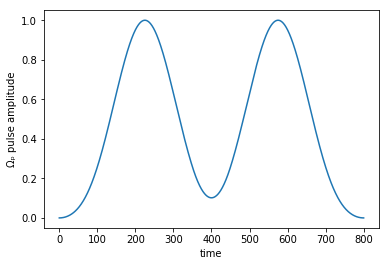

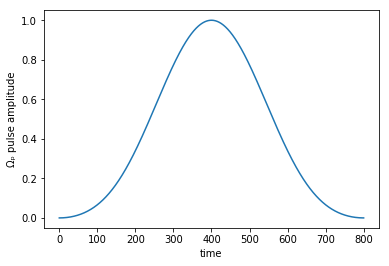

In [19]:
plot_pulse(Ham[1][1], tlist, 'Ωₚ')
plot_pulse(Ham[3][1], tlist, 'Ωₚ')

## Optimize

<div class="alert alert-block alert-success">
    
**Here we have a problem!!!**

This does currently not work (on my machine). It does not give an error, but shuts down the kernel...

**MG**: I'm assuming you were able to fix this by not installing qutip through conda (see comment in the `Makefile`)
</div>


<div class="alert alert-block alert-info">MK: 
    Yes I did!
</div>

In [20]:
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity, iter_stop=3)

NotImplementedError: Cannot handle argument types A:oper, state:oper

<div class="alert alert-block alert-danger">
MG: this might actually be a bug... ham_mapping might be wrong. Needs some further analysis.
</div>

<div class="alert alert-block alert-info">
MK: Now I have a problem using the density matrix in the objectives.
    I haven't found anything similar to that in the other notebooks
    (except for 04, where the Liouvillian is used.)
    Sould I also convert the Hamiltonian to a Liouvillian? Or will this feaure come soon?
</div>